<a href="https://colab.research.google.com/github/indra622/tutorials/blob/master/Multi_AI_Agent_Study/Part3_Ch1_04_Langgraph_with_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install langgraph langchain-openai python-dotenv langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.2 MB/s eta 0:00:00


In [5]:
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

class State(TypedDict):
  messages: Annotated[list, add_messages]


tool = TavilySearchResults(max_results=2)
tool_node = ToolNode([tool])

llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools([tool])

def chatbot(state: State):
  result = llm_with_tools.invoke(state['messages'])
  return {"messages": [result]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [7]:
config = {"configurable": {"thread_id": "1"}}

while True:
  user_input = input("User: ")
  if user_input.lower() in ['quit', 'exit', 'q']:
    print("Goodbye!")
    break
  for event in graph.stream({"messages": ("user", user_input)}, config):
    for value in event.values():
      print("Assistant:", value["messages"][-1].content)

User: 대한민국의 대통령은 누구야?
Assistant: 
Assistant: [{"url": "https://en.wikipedia.org/wiki/President_of_South_Korea", "content": "The current president, Yoon Suk Yeol, a former prosecutor general and member of the conservative People Power Party, assumed office on 10 May 2022,[3][4] after defeating the Democratic Party's nominee Lee Jae-myung with a narrow 48.5% plurality in the 2022 South Korean presidential election.[5]\nHistory[edit]\nPrior to the establishment of the First Republic in 1948, the Provisional Government of the Republic of Korea established in Shanghai in September 1919 as the continuation of several governments proclaimed in the aftermath of March 1st Movement earlier that year coordinated resistance against Japanese rule. However, such individuals are still entitled to retain security protection under the Presidential Security Act.[15]\nOrder of succession[edit]\nArticle 71 of the Constitution of South Korea states, 'In the event of the president not being able to discharg

thread id에 따라서 대화 저장이 결정됨

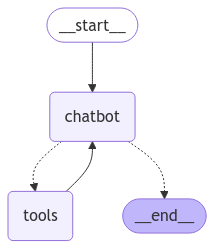

In [8]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='대한민국의 대통령은 누구야?', additional_kwargs={}, response_metadata={}, id='39da4695-9d82-4df6-a582-0a2681713070'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_o9aBAoRcQKbcLaHWDSkFqzWX', 'function': {'arguments': '{"query":"current president of South Korea"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 87, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ed64939-d74d-402d-a5ac-565ef988f218-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current president of South Korea

In [10]:
config2 = {"configurable": {"thread_id": "2"}}

graph.invoke({"messages": [{"role":"user", "content": "내가 한 첫 질문이 뭐였어?"}]}, config2)

{'messages': [HumanMessage(content='내가 한 첫 질문이 뭐였어?', additional_kwargs={}, response_metadata={}, id='b9c2cc3e-860e-4aaf-94a7-62095069587f'),
  AIMessage(content='죄송하지만, 이전 대화 내용을 기억하거나 저장할 수는 없습니다. 하지만 새로 질문해 주시면 최대한 도움을 드리겠습니다!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 89, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'stop', 'logprobs': None}, id='run-a6a8b2d6-39d5-4dda-b90d-12066b5c57b5-0', usage_metadata={'input_tokens': 89, 'output_tokens': 33, 'total_tokens': 122, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [11]:
def filter_messages(messages: list):
  return messages[-2:]

def chatbot(state: State):
  messages = filter_messages(state["messages"])
  result = llm_with_tools.invoke(messages)
  return {"messages": [result]}

graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', tool_node)
graph_builder.add_edge('chatbot', 'tools')
graph_builder.add_conditional_edges('chatbot', tools_condition)
graph_builder.set_entry_point('chatbot')

graph = graph_builder.compile(checkpointer=memory)

In [12]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "20"}}
input_message = HumanMessage(content="hi! I'm bob and I like soccer")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# This will now not remember the previous messages
# (because we set `messages[-1:]` in the filter messages argument)
input_message = HumanMessage(content="what's my name?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

input_message = HumanMessage(content="what's my name?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

input_message = HumanMessage(content="what's my favorite?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob and I like soccer
================================== Ai Message ==================================

Hi Bob! That's great to hear! Soccer is an exciting sport with a rich history and a huge fan base worldwide. Do you have a favorite team or player?
================================== Ai Message ==================================

Hi Bob! That's great to hear! Soccer is an exciting sport with a rich history and a huge fan base worldwide. Do you have a favorite team or player?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob!
================================== Ai Message ==================================

Your name is Bob!
================================ Human Message =================================

what's my name?
================================